# 6-1. 프로젝트: 인물 모드 문제점 찾기

> 코드 및 설명

In [2]:
import os
import cv2
import numpy as np
from pixellib.semantic import semantic_segmentation
from matplotlib import pyplot as plt

- os, cv2, numpy, semantic_segmentation 및 pyplot 라이브러리를 임포트합니다.

In [3]:
# 이미지 경로 설정
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/image/image_1.png'  # 인물모드 사진의 경로
bg_path = os.getenv('HOME')+'/aiffel/human_segmentation/image/background_1.png'  # 새로운 배경 이미지의 경로

- 인물 모드 사진 (image_1.png)과 새로운 배경 이미지 (background_1.png)의 경로를 설정합니다.

In [4]:
img_orig = cv2.imread(img_path) 
bg_orig = cv2.imread(bg_path) 

print(img_orig.shape)
print(bg_orig.shape)

(512, 512, 3)
(512, 819, 3)


- cv2.imread() 함수를 사용하여 인물 모드 사진과 배경 이미지를 원본으로 읽어옵니다.
- shape 속성을 사용하여 이미지의 크기를 출력합니다.

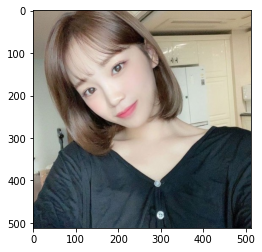

In [5]:
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

- cv2.cvtColor() 함수를 사용하여 BGR 형식의 이미지를 RGB 형식으로 변환한 후, imshow() 함수를 통해 인물 모드 사진을 출력합니다.

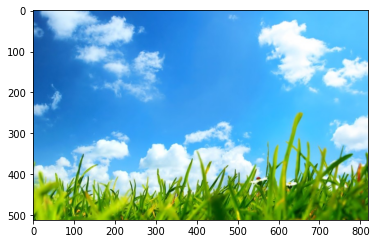

In [6]:
plt.imshow(cv2.cvtColor(bg_orig, cv2.COLOR_BGR2RGB))
plt.show()

- 배경 이미지도 동일한 방식으로 출력합니다.

In [7]:
# 시맨틱 세그멘테이션 모델 로드
model_dir = os.getenv('HOME') + '/aiffel/human_segmentation/models'
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')
model = semantic_segmentation()
model.load_pascalvoc_model(model_file)

- 시맨틱 세그멘테이션 모델을 불러옵니다. 모델 파일은 deeplabv3_xception_tf_dim_ordering_tf_kernels.h5로 지정되어 있으며, 
- 해당 모델을 load_pascalvoc_model() 함수를 사용하여 로드합니다.

In [8]:
# 인물모드 사진 생성 및 배경 블러링
def create_blurred_portrait(image_path):
    img_orig = cv2.imread(image_path)  # 이미지 파일 읽기

    # 시맨틱 세그멘테이션 수행
    segvalues, output = model.segmentAsPascalvoc(image_path)

    seg_color = (128,128,192)  # 세그멘테이션 색상 설정
    seg_map = np.all(output==seg_color, axis=-1)  # 세그멘테이션 결과 맵 생성

    img_mask = seg_map.astype(np.uint8) * 255  # 이진 마스크 생성
    img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
    img_bg_mask = cv2.bitwise_not(img_mask_color)
    
    img_orig_blur = cv2.blur(img_orig, (13,13))

    img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask) 
    img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)

    return img_concat

- create_blurred_portrait() 함수는 인물 모드 사진에 블러 효과를 적용하는 함수입니다.
- 먼저, 인물 모드 사진을 읽고 시맨틱 세그멘테이션을 수행하여 결과를 얻습니다.
- 특정 색상을 기준으로 세그멘테이션 결과를 생성하고, 이를 바탕으로 이진 마스크를 만듭니다.
- 마스크를 활용하여 원본 이미지에 블러 효과를 적용하고, 배경 부분을 해당 블러 이미지로 대체합니다.

In [9]:
# 배경변경전 작업
def create_portrait_mode2(image_path):
    img_orig = cv2.imread(image_path)  # 이미지 파일 읽기
    segvalues, output = model.segmentAsPascalvoc(image_path)  # 시맨틱 세그멘테이션 수행

    seg_color = (128,128,192)  # 세그멘테이션 색상 설정
    seg_map = np.all(output==seg_color, axis=-1)  # 세그멘테이션 결과 맵 생성

    img_mask = seg_map.astype(np.uint8) * 255  # 이진 마스크 생성
    img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)  # 마스크를 컬러 이미지로 변환

    img_concat = np.where(img_mask_color == 255, img_orig, 0)  # 배경 부분을 검은색으로 변경

    return img_concat

- create_portrait_mode2() 함수는 배경변경 인물사진과 배경을 나눠주는 함수입니다.
- 마스크를 활용하여 배경 부분을 검은색으로 변경합니다.

In [10]:
# 배경 교체 및 블러링
def blur_background(image_path, bg_path):
    img_portrait = create_portrait_mode2(image_path)  # 인물모드 사진 생성
    img_bg = cv2.imread(bg_path)  # 새로운 배경 이미지 읽기

    img_bg = cv2.resize(img_bg, (img_portrait.shape[1], img_portrait.shape[0]))  # 배경 이미지 크기 조정

    # 배경 블러링
    img_blur = cv2.GaussianBlur(img_bg, (101, 101), 0)  # 배경을 가우시안 블러링

    img_concat = np.where(img_portrait == 0, img_blur, img_portrait)  # 배경 교체

    return img_concat

- blur_background() 함수는 인물 모드 사진의 배경을 새로운 배경으로 블러링하는 함수입니다.
- create_portrait_mode2() 함수를 사용하여 인물 모드 사진을 생성하고, 새로운 배경 이미지를 읽습니다.
-  배경 이미지의 크기를 인물 모드 사진과 동일하게 조정한 후, 가우시안 블러링을 적용합니다.
- 인물 모드 사진의 배경을 블러 이미지로 대체하여 최종 결과 이미지를 생성합니다.

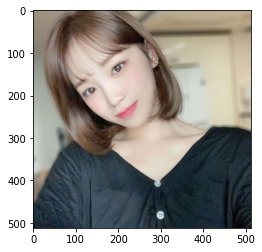

In [11]:
# 배경 블러링
portrait_image = create_blurred_portrait(img_path)
plt.imshow(cv2.cvtColor(portrait_image, cv2.COLOR_BGR2RGB))
plt.show()

- create_blurred_portrait() 함수를 사용하여 인물 모드 사진에 블러 효과를 적용한 결과를 시각화하여 출력합니다.

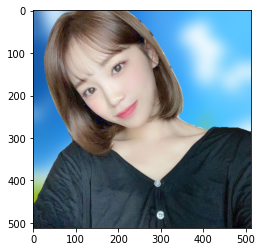

In [12]:
# 배경 교체 및 블러링
blurred_image = blur_background(img_path, bg_path)
plt.imshow(cv2.cvtColor(blurred_image, cv2.COLOR_BGR2RGB))
plt.show()

- blur_background() 함수를 사용하여 인물 모드 사진의 배경을 새로운 배경으로 블러링한 결과를 시각화하여 출력합니다.

> 추가 이미지 변경작업

In [13]:
# 두 번째 이미지 경로 설정
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/image/image_2.png'  # 인물모드 사진의 경로
bg_path = os.getenv('HOME')+'/aiffel/human_segmentation/image/background_2.png'  # 새로운 배경 이미지의 경로

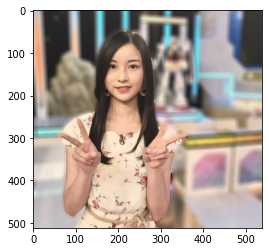

In [14]:
# 두 번째 배경 블러링
portrait_image = create_blurred_portrait(img_path)
plt.imshow(cv2.cvtColor(portrait_image, cv2.COLOR_BGR2RGB))
plt.show()

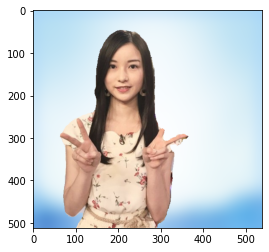

In [15]:
# 두 번째 배경 교체 및 블러링
blurred_image = blur_background(img_path, bg_path)
plt.imshow(cv2.cvtColor(blurred_image, cv2.COLOR_BGR2RGB))
plt.show()

In [16]:
# 세 번째 이미지 경로 설정
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/image/image_3.png'  # 인물모드 사진의 경로
bg_path = os.getenv('HOME')+'/aiffel/human_segmentation/image/background_3.png'  # 새로운 배경 이미지의 경로

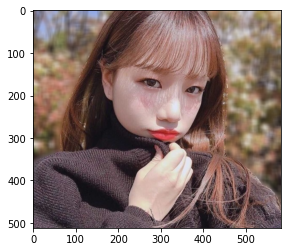

In [17]:
# 세 번째 배경 블러링
portrait_image = create_blurred_portrait(img_path)
plt.imshow(cv2.cvtColor(portrait_image, cv2.COLOR_BGR2RGB))
plt.show()

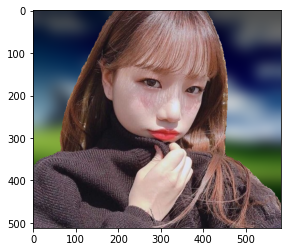

In [19]:
# 세 번째 배경 교체 및 블러링
blurred_image = blur_background(img_path, bg_path)
plt.imshow(cv2.cvtColor(blurred_image, cv2.COLOR_BGR2RGB))
plt.show()

In [43]:
# 네 번째 이미지 경로 설정
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/image/image_6.png'  # 인물모드 사진의 경로
bg_path = os.getenv('HOME')+'/aiffel/human_segmentation/image/background_4.png'  # 새로운 배경 이미지의 경로

In [41]:
# 이미지에 블러 효과를 적용하는 함수
def create_blurred_animal(image_path):
    img_orig = cv2.imread(image_path)  # 이미지 파일 읽기

    # 시맨틱 세그멘테이션 수행
    segvalues, output = model.segmentAsPascalvoc(image_path)

    seg_color = (128, 0, 0)  # 세그멘테이션 색상 설정 (동물은 붉은색으로 지정)
    seg_map = np.all(output == seg_color, axis=-1)  # 세그멘테이션 결과 맵 생성

    img_mask = seg_map.astype(np.uint8) * 255  # 이진 마스크 생성
    img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
    img_bg_mask = cv2.bitwise_not(img_mask_color)

    img_orig_blur = cv2.blur(img_orig, (13, 13))

    img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
    img_concat = np.where(img_mask_color == 255, img_orig, img_bg_blur)

    return img_concat

In [36]:
# 새로운 동물사진 생성 함수
def create_animal_mode2(image_path):
    img_orig = cv2.imread(image_path)  # 이미지 파일 읽기
    segvalues, output = model.segmentAsPascalvoc(image_path)  # 시맨틱 세그멘테이션 수행

    seg_color = (128, 0, 0)  # 세그멘테이션 색상 설정 (동물은 붉은색으로 지정)
    seg_map = np.all(output == seg_color, axis=-1)  # 세그멘테이션 결과 맵 생성

    img_mask = seg_map.astype(np.uint8) * 255  # 이진 마스크 생성
    img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)  # 마스크를 컬러 이미지로 변환

    img_concat = np.where(img_mask_color == 255, img_orig, 0)  # 배경 부분을 검은색으로 변경

    return img_concat


In [37]:
# 배경 블러링 함수
def blur_background(image_path, bg_path):
    img_animal = create_animal_mode2(image_path)  # 동물모드 사진 생성
    img_bg = cv2.imread(bg_path)  # 새로운 배경 이미지 읽기

    img_bg = cv2.resize(img_bg, (img_animal.shape[1], img_animal.shape[0]))  # 배경 이미지 크기 조정

    # 배경 블러링
    img_blur = cv2.GaussianBlur(img_bg, (101, 101), 0)  # 배경을 가우시안 블러링

    img_concat = np.where(img_animal == 0, img_blur, img_animal)  # 배경 교체

    return img_concat

In [40]:
# 네 번째 배경 블러링
blurred_animal_image = create_blurred_animal(img_path)
plt.imshow(cv2.cvtColor(blurred_animal_image, cv2.COLOR_BGR2RGB))
plt.show()

AttributeError: module 'cv2.cv2' has no attribute 'bitwise'

- module 'cv2.cv2' has no attribute 'bitwise' 에러는 OpenCV 모듈에 bitwise라는 속성이 없어서 발생하는 오류입니다.
  위 코드에서 cv2.bitwise를 사용하는 부분을 확인해보니,
  실제로 OpenCV 모듈에는 bitwise_and, bitwise_or, bitwise_not 등의 속성이 있지만 bitwise는 존재하지 않아서
  bitwise_and로 사용했습니다.

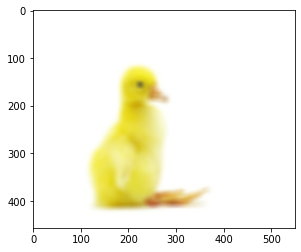

In [44]:
# 네 번째 배경 블러링
blurred_animal_image = create_blurred_animal(img_path)
plt.imshow(cv2.cvtColor(blurred_animal_image, cv2.COLOR_BGR2RGB))
plt.show()

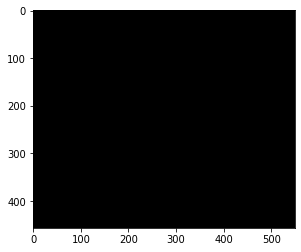

In [46]:
# 네 번째 배경 교체 및 블러링
blurred_image = create_animal_mode2(img_path)
plt.imshow(cv2.cvtColor(blurred_image, cv2.COLOR_BGR2RGB))
plt.show()

- 동물사진 분리에는 실패했습니다...

> 회고

이번 프로젝트는 결과가 좋지않아 아쉬웠습니다. 이미지 세그멘테이션을 작업하면서 이것 저것 파라미터 튜닝도 해보고
결과도 분석해보고 여러가지 다른모델에 대해서도 많이 찾아봤습니다.
앞으로 어떤방향으로 나아갈지는 모르지만 이번 프로젝트를 하면서 이 작업이 저에게 흥미가 매우 있었습니다.

> 해결 방법을 제안해 보기

1. DeepLab

    DeepLab v1~v3+ architecture는 구글에서 제시한 모델로, 2015년부터 현재에 이르기까지 계속해서 업데이트를 하고있는 모델입니다. DeepLab 시리즈는 여러 segmentation model 중 성능이 상위권에 포진되어있습니다.

    DeepLab 시리즈의 발전은 아래와 같이 이루어졌는데, 최근 모델들은 모두 앞선 모델들을 계승하면서 조금씩 추가되는 항목이 생깁니다. 아래 개념들을 하나씩 살펴보면서 각 모델 별 차이점을 알아보겠습니다.

    DeepLab V1 : Atrous convolution을 처음 적용
    DeepLab V2 : multi-scale context를 적용하기 위한 Atrous spatial pyramid pooling(ASPP) 제안
    DeepLab V3 : 기존 ResNet 구조에 Atrous convolution을 활용
    DeepLab V3+ : Depthwise separable convolution과 Atrous convolution을 결합한 Atrous separable convolution을 제안.

참고 링크

[최신의 DeepLab V3+ 설명 링크](https://wikidocs.net/143446)

2. Vision Transformer (ViT)

    Vision Transformer(ViT)는 이미지 인식 및 처리 작업에서 높은 성능을 발휘하는 딥러닝 모델로, 자연어 처리(NLP) 분야에서 성공을 거둔 Transformer 구조를 컴퓨터 비전 분야에 적용한 모델입니다. 기존의 Convolutional Neural Networks(CNNs) 대신 Transformer 구조를 사용함으로써, 전역적인 이미지 정보를 적절하게 포착하고 처리할 수 있습니다.

    Vision Transformer는 이미지에서 전역적인 정보와 상호작용하는 요소들을 포착하고, 다양한 컴퓨터 비전 작업에 높은 성능을 발휘하고 있습니다. 다양한 문제와 데이터셋에도 잘 적용될 수 있어 최근 여러 분야에 널리 사용되고 있는 모델입니다.

참고링크

[ViT의 정의, 원리, 구현, 응용분야](https://www.thedatahunt.com/trend-insight/vision-transformer)

3. Mask R-CNN

    Mask R-CNN은 Faster R-CNN의 RPN에서 얻은 RoI(Region of Interest)에 대하여 객체의 class를 예측하는 classification branch, bbox regression을 수행하는 bbox regression branch와 평행으로 segmentation mask를 예측하는 mask branch를 추가한 구조를 가지고 있습니다. 

참고링크

[Mask R-CNN 논문(Mask R-CNN) 리뷰](https://herbwood.tistory.com/20)

4. FCN

    FCN은 컨볼루션 신경망을 사용하여 픽셀 수준 세그멘테이션을 수행하는 방법입니다. 이미지의 특징을 추출하고, 업샘플링을 통해 원래 이미지 크기로 복원하는 과정을 거치면서 세그멘테이션 맵을 얻을 수 있습니다.

참고링크

[딥러닝/FCN (Fully Convolutional Networks)](https://dbstndi6316.tistory.com/263)

5. U-Net++

    U-Net의 개선 버전인 U-Net++는 U-Net 구조를 확장하여 더욱 정확한 세그멘테이션 결과를 얻을 수 있도록 설계된 방법입니다. 다양한 크기의 특징 맵을 결합하여 다중 해상도 세그멘테이션을 수행합니다.

참고링크

[UNet++ 설명 링크](https://wsshin.tistory.com/2)